# Video Anomaly Detection (UCF-Crime) — Pipeline reproducible

Este notebook implementa un pipeline reproducible para detección binaria de anomalías en video.

## Objetivo general
Construir un flujo estable que permita:
1) Indexar el dataset y construir una etiqueta binaria (Normal vs Anomalía).
2) Generar splits reproducibles (train/val/test) a nivel de video (sin leakage).
3) Extraer embeddings con TimeSformer (base) y almacenarlos a disco.
4) Optimizar un clasificador MLP con Optuna usando embeddings base y congelarlo.
5) Adaptar TimeSformer con LoRA (config fija), re-extraer embeddings y evaluar con el MLP fijo.

## Principios técnicos
- No acumular embeddings en RAM (se guardan incrementalmente a disco).
- Mantener splits fijos y reproducibles.
- Mantener el set de test completamente aislado.


In [1]:
import os
import gc
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd

print("PID:", os.getpid())
print("CWD:", os.getcwd())


PID: 135597
CWD: /home/DIINF/dvaldes/tesis


In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

print("SEED:", SEED)


SEED: 42


## Estructura de proyecto y artefactos

Se definen rutas canónicas para:
- `PROJECT_ROOT`: raíz del proyecto en el servidor
- `DATASET_ROOT`: ubicación del dataset UCF-Crime
- `PROCESSED_DIR`: carpeta con índices y splits (fuente única de verdad)
- `ARTIFACTS_DIR`: carpeta de resultados por experimento

Regla: todo artefacto generado se guarda en disco inmediatamente para evitar pérdida por reinicios.


In [3]:
USER = "dvaldes"
PROJECT_ROOT = Path("/home/DIINF/dvaldes/tesis")
DATASET_ROOT = PROJECT_ROOT / "UCF_Crime"
PROCESSED_DIR = PROJECT_ROOT / "processed"

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Usuario:", USER)
print("PROJECT_ROOT:", PROJECT_ROOT, "| exists:", PROJECT_ROOT.exists())
print("DATASET_ROOT exists:", DATASET_ROOT.exists())
print("PROCESSED_DIR exists:", PROCESSED_DIR.exists())
print("ARTIFACTS_DIR exists:", ARTIFACTS_DIR.exists())


Usuario: dvaldes
PROJECT_ROOT: /home/DIINF/dvaldes/tesis | exists: True
DATASET_ROOT exists: True
PROCESSED_DIR exists: True
ARTIFACTS_DIR exists: True


# Etapa 1 — Indexación del dataset (Normal vs Anomalía)

En esta etapa se construye un índice binario reproducible del dataset UCF-Crime.

## Objetivo
Generar un CSV estructurado con:
- Ruta absoluta y relativa del video
- Etiqueta binaria: `y=0` (Normal), `y=1` (Anomalía)
- Tipo de anomalía (solo para trazabilidad)

## Definición de clase positiva (Anomalía=1)
Se seleccionan cinco tipos de anomalías para conformar el conjunto positivo:
- Robbery, Assault, Vandalism, Abuse, Fighting

La clasificación del modelo es estrictamente binaria; las categorías solo aportan trazabilidad.


In [4]:
TARGET_ANOMALY_FOLDERS = {
    "Robbery":   "Anomaly-Videos-Part-3/Robbery",
    "Assault":   "Anomaly-Videos-Part-1/Assault",
    "Vandalism": "Anomaly-Videos-Part-4/Vandalism",
    "Abuse":     "Anomaly-Videos-Part-1/Abuse",
    "Fighting":  "Anomaly-Videos-Part-2/Fighting",
}

ANOMALY_ES = {
    "Robbery": "Robo",
    "Assault": "Asalto",
    "Vandalism": "Vandalismo",
    "Abuse": "Maltrato",
    "Fighting": "Peleas",
}

NORMAL_FOLDERS = [
    "Training-Normal-Videos-Part-1",
    "Training-Normal-Videos-Part-2",
    "Testing_Normal_Videos_Anomaly",
]

print("TARGET_ANOMALY_FOLDERS:", TARGET_ANOMALY_FOLDERS)
print("NORMAL_FOLDERS:", NORMAL_FOLDERS)


TARGET_ANOMALY_FOLDERS: {'Robbery': 'Anomaly-Videos-Part-3/Robbery', 'Assault': 'Anomaly-Videos-Part-1/Assault', 'Vandalism': 'Anomaly-Videos-Part-4/Vandalism', 'Abuse': 'Anomaly-Videos-Part-1/Abuse', 'Fighting': 'Anomaly-Videos-Part-2/Fighting'}
NORMAL_FOLDERS: ['Training-Normal-Videos-Part-1', 'Training-Normal-Videos-Part-2', 'Testing_Normal_Videos_Anomaly']


In [5]:
anom_records = []

for anomaly_type, rel_folder in TARGET_ANOMALY_FOLDERS.items():
    folder = DATASET_ROOT / rel_folder
    if not folder.exists():
        print(f"[WARN] No existe la carpeta de anomalías: {folder}")
        continue

    mp4s = list(folder.glob("*.mp4"))
    if len(mp4s) == 0:
        print(f"[WARN] Sin .mp4 en: {folder}")
        continue

    for video_path in mp4s:
        anom_records.append({
            "path_abs": str(video_path.resolve()),
            "path_rel": str(video_path.relative_to(DATASET_ROOT)),
            "y": 1,
            "anomaly_type": anomaly_type,
            "anomaly_es": ANOMALY_ES.get(anomaly_type, anomaly_type),
            "source_folder": str(rel_folder),
        })

df_anom = pd.DataFrame(anom_records)
print("Anomalías indexadas:", len(df_anom))
df_anom["anomaly_type"].value_counts()


Anomalías indexadas: 350


anomaly_type
Robbery      150
Assault       50
Vandalism     50
Abuse         50
Fighting      50
Name: count, dtype: int64

In [6]:
norm_records = []

for rel_folder in NORMAL_FOLDERS:
    folder = DATASET_ROOT / rel_folder
    if not folder.exists():
        print(f"[WARN] No existe carpeta normal: {folder}")
        continue

    mp4s = list(folder.rglob("*.mp4"))
    if len(mp4s) == 0:
        print(f"[WARN] Sin .mp4 en: {folder}")
        continue

    for video_path in mp4s:
        norm_records.append({
            "path_abs": str(video_path.resolve()),
            "path_rel": str(video_path.relative_to(DATASET_ROOT)),
            "y": 0,
            "anomaly_type": "Normal",
            "anomaly_es": "Normal",
            "source_folder": str(rel_folder),
        })

df_norm = pd.DataFrame(norm_records)
print("Normales indexados:", len(df_norm))


Normales indexados: 950


# Etapa 2 — Validación del índice y análisis de desbalance

Se valida:
- Duplicados por `path_rel`
- Existencia física de rutas
- Distribución de clases (Normal vs Anomalía)
- Distribución por tipo anómalo (solo análisis)

Esto permite anticipar desbalance y definir estrategias posteriores (p.ej., class weights).


In [7]:
from pathlib import Path as _Path

df_index = pd.concat([df_anom, df_norm], ignore_index=True)

dup = df_index.duplicated(subset=["path_rel"]).sum()
missing = (~df_index["path_abs"].apply(lambda p: _Path(p).exists())).sum()

print("Duplicados por path_rel:", dup)
print("Rutas inexistentes:", missing)

dist = df_index["y"].value_counts().rename_axis("y").reset_index(name="count")
print(dist)

anom_rate = df_index["y"].mean() * 100
print(f"% anomalía en el índice: {anom_rate:.2f}%")

index_path = PROCESSED_DIR / "preprocess_index_binary.csv"
df_index.to_csv(index_path, index=False)
print("Índice guardado en:", index_path, "| filas:", len(df_index))


Duplicados por path_rel: 0
Rutas inexistentes: 0
   y  count
0  0    950
1  1    350
% anomalía en el índice: 26.92%
Índice guardado en: /home/DIINF/dvaldes/tesis/processed/preprocess_index_binary.csv | filas: 1300


# Etapa 3 — Partición del dataset (Train / Validation / Test)

La partición se realiza a nivel de video completo para evitar *data leakage*.

- Train: 70%
- Validation: 15%
- Test: 15%

Se utiliza estratificación por `y` para mantener proporciones similares de Normal/Anomalía en cada split.


In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_index,
    test_size=0.30,
    random_state=SEED,
    stratify=df_index["y"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["y"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train dist:\n", train_df["y"].value_counts())
print("Val dist:\n", val_df["y"].value_counts())
print("Test dist:\n", test_df["y"].value_counts())

(PROCESSED_DIR / "split_train.csv").write_text(train_df.to_csv(index=False))
(PROCESSED_DIR / "split_val.csv").write_text(val_df.to_csv(index=False))
(PROCESSED_DIR / "split_test.csv").write_text(test_df.to_csv(index=False))

print("Splits guardados en:", PROCESSED_DIR)


Train: 910 Val: 195 Test: 195
Train dist:
 y
0    665
1    245
Name: count, dtype: int64
Val dist:
 y
0    142
1     53
Name: count, dtype: int64
Test dist:
 y
0    143
1     52
Name: count, dtype: int64
Splits guardados en: /home/DIINF/dvaldes/tesis/processed


# Etapa 4 — Extracción de embeddings  
**TimeSformer Base (preentrenado, sin LoRA)**

## Descripción general
En esta etapa se realiza la **extracción de embeddings espacio–temporales a nivel de clip** utilizando el modelo **TimeSformer Base preentrenado**, operando exclusivamente en **modo inferencia**.  
Cada video es dividido en un número acotado de clips temporales, desde los cuales se generan representaciones vectoriales que posteriormente serán utilizadas en la etapa de clasificación de anomalías.

El proceso está diseñado explícitamente para **evitar caídas del servidor**, priorizando estabilidad, trazabilidad y reproducibilidad por sobre velocidad de ejecución.

---

## Objetivo de la etapa
- Extraer embeddings por clip para los conjuntos `train`, `val` y `test`.
- Evitar la acumulación de datos en memoria RAM o VRAM.
- Persistir los embeddings incrementalmente en disco.
- Construir un índice estructurado (`index_embeddings.csv`) que permita:
  - trazabilidad por `video_id` y `clip_id`,
  - asociación con la etiqueta `y`,
  - reanudación segura del proceso ante fallas.

---




In [9]:
import json
from pathlib import Path

# =========================================================
# Experimento
# =========================================================
EXP_NAME = "exp01_timesformer_base"
EXP_DIR = ARTIFACTS_DIR / EXP_NAME
EMB_DIR = EXP_DIR / "embeddings"

EXP_DIR.mkdir(parents=True, exist_ok=True)
EMB_DIR.mkdir(parents=True, exist_ok=True)

# =========================================================
# Config de extracción (TimeSformer Base, sin LoRA)
# =========================================================
EXTRACT_CFG = {
    # Reproducibilidad
    "seed": SEED,

    # Muestreo / segmentación temporal
    "fps": 32,
    "clip_len": 16,
    "stride": 32,
    "max_clips_per_video": 8,

    # Data loading (estabilidad)
    "batch_size": 1,
    "num_workers": 0,

    # Control duro de memoria (estabilidad)
    "hard_cap_frames": 512,   # techo máximo aunque el config pida más
    "decord_chunk": 64,       # lectura en bloques para evitar picos de RAM
    "max_frames": None,       # se deriva abajo para evitar desalineación

    # Resolución espacial (calidad)
    "resize_short": 224,
    "crop_size": 224,

    # Inferencia eficiente
    "use_amp": True,
    "amp_dtype": "float16",

    # Modelo
    "device": "cuda",
    "encoder_name": "TimeSformer",
    "encoder_variant": "base_pretrained",

    # Notas
    "notes": "Extracción base SIN LoRA. Guardado incremental a disco.",
}

# ---------------------------------------------------------
# Derivación coherente (evita hardcode y errores)
# max_frames = (max_clips_per_video - 1) * stride + clip_len
# ---------------------------------------------------------
EXTRACT_CFG["max_frames"] = (
    (EXTRACT_CFG["max_clips_per_video"] - 1) * EXTRACT_CFG["stride"]
    + EXTRACT_CFG["clip_len"]
)

# =========================================================
# Persistencia de config (reproducibilidad)
# =========================================================
cfg_path = EXP_DIR / "config_extract_base.json"
with open(cfg_path, "w") as f:
    json.dump(EXTRACT_CFG, f, indent=2)

print("EXP_DIR:", EXP_DIR)
print("EMB_DIR:", EMB_DIR)
print("Config guardada en:", cfg_path)
print("max_frames calculado:", EXTRACT_CFG["max_frames"])


EXP_DIR: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base
EMB_DIR: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/embeddings
Config guardada en: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/config_extract_base.json
max_frames calculado: 240


## Cargar splits desde `processed/`

Se cargan los CSV generados previamente para asegurar que toda extracción se realiza sobre el mismo split a nivel de video (sin leakage).


In [10]:
train_df = pd.read_csv(PROCESSED_DIR / "split_train.csv")
val_df   = pd.read_csv(PROCESSED_DIR / "split_val.csv")
test_df  = pd.read_csv(PROCESSED_DIR / "split_test.csv")

print("Train:", train_df.shape, "| anom_rate:", train_df["y"].mean())
print("Val:  ", val_df.shape,   "| anom_rate:", val_df["y"].mean())
print("Test: ", test_df.shape,  "| anom_rate:", test_df["y"].mean())

# sanity: columnas esperadas
expected_cols = {"path_abs","path_rel","y","anomaly_type","anomaly_es","source_folder"}
assert expected_cols.issubset(set(train_df.columns)), "Faltan columnas en train_df"


Train: (910, 6) | anom_rate: 0.2692307692307692
Val:   (195, 6) | anom_rate: 0.2717948717948718
Test:  (195, 6) | anom_rate: 0.26666666666666666


## Chequeo de dependencias y GPU

Antes de cargar TimeSformer, se valida:
- disponibilidad de `torch`
- disponibilidad de GPU
- versión de dependencias

Esto permite detectar de inmediato fallas típicas antes de ejecutar extracción masiva.


In [11]:
import torch

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA capability:", torch.cuda.get_device_capability(0))


Torch: 2.9.1+cu128
CUDA available: True
GPU: Quadro RTX 6000
CUDA capability: (7, 5)


# Etapa 4.1 — Carga del codificador TimeSformer (HuggingFace)

En esta sección se carga el modelo TimeSformer preentrenado usando `transformers`.

## Objetivo
- Verificar dependencias (`transformers`)
- Cargar un modelo base (`TimesformerModel`) para extraer embeddings
- Preparar `image_processor` para normalizar los frames de entrada

## Principio anti-caída
- Verificar versiones antes de ejecutar extracción masiva
- Cargar el modelo en `eval()` y con `torch.no_grad()` cuando corresponda


In [12]:
import importlib

def _is_installed(pkg: str) -> bool:
    return importlib.util.find_spec(pkg) is not None

print("transformers installed:", _is_installed("transformers"))

if not _is_installed("transformers"):
    raise RuntimeError(
        "No está instalado `transformers`. Instálalo con: pip install transformers"
    )


transformers installed: True


## Selección del checkpoint

Se utilizará un checkpoint preentrenado disponible en HuggingFace.

Criterios:
- Pesos públicos
- Arquitectura estándar (base)
- Compatible con extracción de embeddings (sin cabeza final)

Nota: El nombre exacto del checkpoint puede variar. La celda siguiente intentará cargar uno y, si falla, ajustaremos al ID correcto disponible en tu entorno.


In [13]:
import torch
from transformers import TimesformerModel, AutoImageProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# Checkpoint (si falla, lo ajustamos con el error exacto)
TIMESFORMER_CKPT = "facebook/timesformer-base-finetuned-k400"

image_processor = AutoImageProcessor.from_pretrained(TIMESFORMER_CKPT)
encoder = TimesformerModel.from_pretrained(TIMESFORMER_CKPT)

encoder.to(DEVICE)
encoder.eval()

print("Loaded checkpoint:", TIMESFORMER_CKPT)
print("Model type:", type(encoder))
print("Image processor:", type(image_processor))


DEVICE: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded checkpoint: facebook/timesformer-base-finetuned-k400
Model type: <class 'transformers.models.timesformer.modeling_timesformer.TimesformerModel'>
Image processor: <class 'transformers.models.videomae.image_processing_videomae.VideoMAEImageProcessor'>


## Test mínimo: forward pass con datos dummy

Antes de procesar videos reales, se realiza una prueba con un tensor dummy para validar:
- shapes esperados
- que el modelo corre en GPU/CPU sin error

Esto evita que falle más adelante después de horas de extracción.


In [16]:
import numpy as np

# Dummy video: batch=1, frames=8, channels=3, height=224, width=224
# Nota: usamos pocos frames para test rápido.
dummy = np.random.randint(0, 255, size=(8, 224, 224, 3), dtype=np.uint8)

inputs = image_processor(
    list(dummy),  # lista de frames HWC uint8
    return_tensors="pt"
)

# inputs["pixel_values"] suele quedar [frames, 3, H, W] o [1, frames, 3, H, W] según processor
for k, v in inputs.items():
    print(k, v.shape, v.dtype)

# Ajuste: aseguramos batch dimension
pixel_values = inputs["pixel_values"]
if pixel_values.ndim == 4:
    pixel_values = pixel_values.unsqueeze(0)  # [1, T, 3, H, W] o [1, 3, T, H, W] depende del processor

pixel_values = pixel_values.to(DEVICE)

with torch.no_grad():
    out = encoder(pixel_values=pixel_values)

print("Output keys:", out.keys())
print("last_hidden_state shape:", out.last_hidden_state.shape)


pixel_values torch.Size([1, 8, 3, 224, 224]) torch.float32
Output keys: odict_keys(['last_hidden_state'])
last_hidden_state shape: torch.Size([1, 1569, 768])


## Definición del embedding por clip

Para cada clip se obtiene un vector de dimensión fija desde el token CLS:

- `embedding = last_hidden_state[:, 0, :]`

Este embedding se almacenará a disco y será usado como entrada del clasificador MLP.


In [18]:
with torch.no_grad():
    out = encoder(pixel_values=pixel_values)
    emb = out.last_hidden_state[:, 0, :]   # CLS token

print("Embedding shape:", emb.shape)
print("Embedding dtype:", emb.dtype)


Embedding shape: torch.Size([1, 768])
Embedding dtype: torch.float32


# Etapa 4.2 — Lectura de video y muestreo temporal (FPS fijo)

En esta etapa se implementa una función robusta para:
- leer un video desde disco,
- muestrear frames a un FPS objetivo (`fps=32`),
- devolver una lista/array de frames en formato compatible con `image_processor`.


In [19]:
import importlib

HAS_DECORD = importlib.util.find_spec("decord") is not None
HAS_CV2 = importlib.util.find_spec("cv2") is not None

print("HAS_DECORD:", HAS_DECORD)
print("HAS_CV2:", HAS_CV2)

if not HAS_DECORD and not HAS_CV2:
    raise RuntimeError("Necesitas instalar `decord` o `opencv-python` para leer videos.")


HAS_DECORD: True
HAS_CV2: True


## Función `load_video_frames_sampled`

Devuelve frames muestreados a `target_fps` en formato `np.uint8` con shape `[T, H, W, 3]`.

- Entrada: ruta de video
- Salida: `frames` y `meta` (fps real, total frames, etc.)

Si `decord` está disponible, se usa por eficiencia.
Si no, se usa OpenCV como fallback.

Esta función lee un video de forma segura, muestrea los frames a un FPS objetivo, y limita explícitamente cuántos frames carga, para evitar picos de memoria y caídas del servidor.
Devuelve solo los frames necesarios (en RGB) junto con metadatos para trazabilidad.


In [20]:
import numpy as np

def load_video_frames_sampled(
    video_path: str,
    target_fps: int,
    max_frames: int,
    *,
    hard_cap_frames: int,
    decord_chunk: int,
):

    """
    Lee un video y retorna frames muestreados a target_fps.

    Retorna:
      frames: np.ndarray [T, H, W, 3] uint8 (RGB)
      meta: dict con info útil (fps_orig, n_frames_orig, sampled_idx, etc.)
    """
    video_path = str(video_path)

    # 1) Enforzar límite seguro
    if max_frames is None:
        max_frames_eff = hard_cap_frames
    else:
        max_frames_eff = int(min(max_frames, hard_cap_frames))

    if HAS_DECORD:
        from decord import VideoReader, cpu

        vr = VideoReader(video_path, ctx=cpu(0))
        n_frames = len(vr)
        if n_frames == 0:
            raise ValueError("Video sin frames (n_frames=0)")

        fps_orig = float(vr.get_avg_fps()) if hasattr(vr, "get_avg_fps") else 0.0
        if fps_orig <= 1e-6:
            fps_orig = float(target_fps)

        # ratio de muestreo
        step = max(int(round(fps_orig / target_fps)), 1)

        sampled_idx = np.arange(0, n_frames, step, dtype=np.int64)
        if sampled_idx.size == 0:
            raise ValueError("No se generaron índices de muestreo (sampled_idx vacío)")

        sampled_idx = sampled_idx[:max_frames_eff]

        # 2) Leer en chunks para evitar picos de memoria con get_batch
        chunks = []
        for s in range(0, len(sampled_idx), decord_chunk):
            idx_chunk = sampled_idx[s : s + decord_chunk]
            # (t, h, w, 3) uint8-ish
            arr = vr.get_batch(idx_chunk).asnumpy()
            # Asegurar uint8
            if arr.dtype != np.uint8:
                arr = arr.astype(np.uint8, copy=False)
            chunks.append(arr)

        frames = np.concatenate(chunks, axis=0) if len(chunks) > 1 else chunks[0]

        meta = {
            "backend": "decord",
            "fps_orig": fps_orig,
            "n_frames_orig": int(n_frames),
            "target_fps": int(target_fps),
            "step": int(step),
            "n_frames_sampled": int(frames.shape[0]),
            "max_frames_eff": int(max_frames_eff),
            "sampled_idx": sampled_idx.tolist(),  # útil para debug/trazabilidad
        }
        return frames, meta

    # Fallback: OpenCV
    import cv2

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("No se pudo abrir el video con OpenCV")

    fps_orig = cap.get(cv2.CAP_PROP_FPS)
    if fps_orig is None or fps_orig <= 1e-6:
        fps_orig = float(target_fps)

    step = max(int(round(fps_orig / target_fps)), 1)

    # 3) Preasignación: evitamos frames_list + stack (duplica memoria)
    # No conocemos H/W hasta leer el primer frame muestreado.
    frames = None
    sampled_idx = []
    out_t = 0

    i = 0
    grabbed = True
    while grabbed:
        grabbed, frame = cap.read()
        if not grabbed:
            break

        if i % step == 0:
            # OpenCV entrega BGR -> RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            if frames is None:
                h, w, c = frame.shape
                frames = np.empty((max_frames_eff, h, w, c), dtype=np.uint8)

            frames[out_t] = frame
            sampled_idx.append(i)
            out_t += 1

            if out_t >= max_frames_eff:
                break
        i += 1

    cap.release()

    if frames is None or out_t == 0:
        raise ValueError("No se extrajeron frames (posible video corrupto)")

    frames = frames[:out_t]  # recorte al tamaño real

    meta = {
        "backend": "opencv",
        "fps_orig": float(fps_orig),
        "n_frames_orig": int(i),
        "target_fps": int(target_fps),
        "step": int(step),
        "n_frames_sampled": int(frames.shape[0]),
        "max_frames_eff": int(max_frames_eff),
        "sampled_idx": sampled_idx,
    }
    return frames, meta


# Etapa 4.3 — Generación de clips (ventana deslizante)



In [21]:
def make_clip_slices(
    n_frames: int,
    clip_len: int,
    stride: int,
    max_clips: int,
):
    """
    Retorna lista de (start, end) para clips.
    end es exclusivo.
    """
    if n_frames < clip_len:
        return []

    slices = []
    for i in range(max_clips):
        start = i * stride
        end = start + clip_len
        if end > n_frames:
            break
        slices.append((start, end))

    return slices


In [22]:
def encode_clip(encoder, image_processor, clip_frames: np.ndarray, device: str, use_amp: bool = True) -> np.ndarray:
    inputs = image_processor(list(clip_frames), return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    if pixel_values.ndim == 4:
        pixel_values = pixel_values.unsqueeze(0)

    pixel_values = pixel_values.to(device, non_blocking=True)

    encoder.eval()
    with torch.no_grad():
        if device.startswith("cuda") and use_amp:
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                out = encoder(pixel_values=pixel_values)
        else:
            out = encoder(pixel_values=pixel_values)

        emb_t = out.last_hidden_state[:, 0, :]  # [1,768]

    emb = emb_t.squeeze(0).detach().cpu().numpy().astype(np.float32)

    del inputs, pixel_values, out, emb_t
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return emb



In [23]:
import gc
import numpy as np
import torch

def process_one_video_save_memmap(
    row,
    split_name: str,
    cfg: dict,
    encoder,
    image_processor,
    device: str,
    mode: str = "limited",   # "limited" (usa max_clips) o "full" (todo el video)
):
    """
    Procesa 1 video y guarda embeddings por clip en un memmap por video.

    Flujo:
    1) Carga frames muestreados (limitados por cfg para evitar OOM)
    2) Genera slices de clips (limited/full)
    3) Crea memmap [n_clips, emb_dim] y escribe fila a fila
    4) Crea un flag .done al finalizar correctamente (reanudar seguro)

    Retorna:
      records: lista de dicts (uno por clip) para index CSV
      info: dict con estado/meta
    """
    video_path = row["path_abs"]
    video_rel  = row["path_rel"]
    y_label    = int(row["y"])

    # 1) Leer frames muestreados (control de RAM: cfg["max_frames"] y hard_cap_frames)
    frames, meta = load_video_frames_sampled(
        video_path,
        target_fps=cfg["fps"],
        max_frames=cfg["max_frames"],
        hard_cap_frames=cfg["hard_cap_frames"],
        decord_chunk=cfg["decord_chunk"],
    )

    # 2) Generar slices
    if mode == "full":
        slices = make_all_clip_slices(
            n_frames=frames.shape[0],
            clip_len=cfg["clip_len"],
            stride=cfg["stride"],
        )
    else:
        slices = make_clip_slices(
            n_frames=frames.shape[0],
            clip_len=cfg["clip_len"],
            stride=cfg["stride"],
            max_clips=cfg["max_clips_per_video"],
        )

    if not slices:
        return [], {"status": "no_clips", "video_rel": video_rel, "meta": meta}

    # 3) Preparar output
    video_id = make_video_id(video_rel)
    out_dir = get_split_dir(split_name)
    out_dir.mkdir(parents=True, exist_ok=True)

    memmap_path = out_dir / f"{video_id}.mmap"
    done_flag   = out_dir / f"{video_id}.done"

    n_clips = len(slices)
    emb_dim = 768  # TimeSformer Base CLS token dim

    # 3.1) Reanudar seguro:
    # - SOLO saltar si existe el memmap y el flag .done
    # - Si el proceso cayó a mitad de video, puede existir .mmap pero NO .done
    if memmap_path.exists() and done_flag.exists():
        records = []
        for clip_id, (start, end) in enumerate(slices):
            records.append({
                "split": split_name,
                "video_rel": video_rel,
                "video_id": video_id,
                "y": y_label,
                "clip_id": clip_id,
                "start": int(start),
                "end": int(end),
                "emb_path": str(memmap_path),
                "n_clips_video": int(n_clips),
                "n_frames_sampled": int(frames.shape[0]),
                "fps_orig": meta.get("fps_orig", None),
                "skipped": 1,
            })
        return records, {"status": "skipped_done_exists", "video_rel": video_rel, "meta": meta}

    # Si hay un memmap incompleto (existe .mmap pero no .done), lo borramos y recalculamos.
    if memmap_path.exists() and not done_flag.exists():
        try:
            memmap_path.unlink()
        except Exception:
            # Si no se puede borrar, igual intentamos escribir encima con w+
            pass

    # 4) Crear memmap [n_clips, 768] (float16 para reducir tamaño/IO)
    mm = np.memmap(
        memmap_path,
        dtype=np.float16,
        mode="w+",
        shape=(n_clips, emb_dim),
    )

    # 5) Procesar clips y escribir filas
    try:
        for clip_id, (start, end) in enumerate(slices):
            clip_frames = frames[start:end]  # [clip_len, H, W, 3]

            emb = encode_clip(
                encoder=encoder,
                image_processor=image_processor,
                clip_frames=clip_frames,
                device=device,
                use_amp=cfg["use_amp"],
            )  # float32 [768]

            mm[clip_id, :] = emb.astype(np.float16, copy=False)

            # Flush periódico (reduce pérdida si cae en medio)
            if (clip_id + 1) % 10 == 0:
                mm.flush()

        mm.flush()

    finally:
        # Cierre y limpieza siempre (incluso si revienta un clip)
        del mm
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 5.1) Marcar como terminado OK (reanudar seguro)
    done_flag.touch()

    # 6) Construir registros para el índice (uno por clip)
    records = []
    for clip_id, (start, end) in enumerate(slices):
        records.append({
            "split": split_name,
            "video_rel": video_rel,
            "video_id": video_id,
            "y": y_label,
            "clip_id": clip_id,
            "start": int(start),
            "end": int(end),
            "emb_path": str(memmap_path),
            "n_clips_video": int(n_clips),
            "n_frames_sampled": int(frames.shape[0]),
            "fps_orig": meta.get("fps_orig", None),
            "skipped": 0,
        })

    return records, {"status": "ok", "video_rel": video_rel, "meta": meta}


In [24]:
import re
from pathlib import Path

def make_video_id(video_rel: str) -> str:
    """
    Convierte una ruta relativa de video en un ID estable y seguro para archivos.

    Ejemplo:
    'Training/Normal_Videos/Video_001.mp4'
    -> 'Training_Normal_Videos_Video_001_mp4'
    """
    video_rel = str(video_rel)

    # Reemplazar separadores y caracteres problemáticos
    video_id = video_rel.replace("/", "_").replace("\\", "_")
    video_id = video_id.replace(".", "_")

    # Opcional: limpiar cualquier carácter raro
    video_id = re.sub(r"[^a-zA-Z0-9_]", "", video_id)

    return video_id


In [25]:
from pathlib import Path

def get_split_dir(split_name: str) -> Path:
    """
    Retorna el directorio donde se guardan los embeddings del split.
    Ejemplo:
      train -> artifacts/exp01_timesformer_base/embeddings/train
    """
    out_dir = EMB_DIR / split_name
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


# Celda: Smoke test de 1 video (verifica que el pipeline funciona)

In [26]:
from pathlib import Path

# Smoke test: procesa 1 video al azar
row = train_df.sample(1, random_state=SEED).iloc[0]

recs, info = process_one_video_save_memmap(
    row=row,
    split_name="train",
    cfg=EXTRACT_CFG,
    encoder=encoder,
    image_processor=image_processor,
    device=EXTRACT_CFG["device"],   # convención: sale del cfg
    mode="limited",
)

print("Status:", info.get("status"))
print("N records:", len(recs))
print("Ejemplo record:", recs[0] if recs else None)

# Verificar archivo en disco
if recs:
    p = Path(recs[0]["emb_path"])
    print("Memmap exists:", p.exists(), "| path:", p)



Status: skipped_done_exists
N records: 8
Ejemplo record: {'split': 'train', 'video_rel': 'Training-Normal-Videos-Part-2/Normal_Videos508_x264.mp4', 'video_id': 'TrainingNormalVideosPart2_Normal_Videos508_x264_mp4', 'y': 0, 'clip_id': 0, 'start': 0, 'end': 16, 'emb_path': '/home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/embeddings/train/TrainingNormalVideosPart2_Normal_Videos508_x264_mp4.mmap', 'n_clips_video': 8, 'n_frames_sampled': 240, 'fps_orig': 30.0, 'skipped': 1}
Memmap exists: True | path: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/embeddings/train/TrainingNormalVideosPart2_Normal_Videos508_x264_mp4.mmap


# Mini-run (20 videos) para validar estabilidad y tiempos

In [27]:
import pandas as pd
from tqdm.auto import tqdm

mini_n = 20
split_name = "train"

out_csv = EXP_DIR / "index_embeddings_train_mini.csv"
partial_csv = EXP_DIR / "index_embeddings_train_mini.partial.csv"

all_records = []
errors = []

df_mini = train_df.sample(mini_n, random_state=SEED).reset_index(drop=True)

for i in tqdm(range(len(df_mini)), desc=f"Extract {split_name} mini"):
    row = df_mini.iloc[i]
    try:
        recs, info = process_one_video_save_memmap(
            row=row,
            split_name=split_name,
            cfg=EXTRACT_CFG,
            encoder=encoder,
            image_processor=image_processor,
            device=EXTRACT_CFG["device"],
            mode="limited",
        )
        all_records.extend(recs)

    except Exception as e:
        errors.append({"video_rel": row.get("path_rel"), "error": repr(e)})

    # checkpoint cada 5 videos
    if (i + 1) % 5 == 0:
        pd.DataFrame(all_records).to_csv(partial_csv, index=False)

pd.DataFrame(all_records).to_csv(out_csv, index=False)

print("Mini index guardado en:", out_csv)
print("Registros embeddings:", len(all_records))
print("Errores:", len(errors))

if errors:
    display(pd.DataFrame(errors).head(10))


Extract train mini:   0%|          | 0/20 [00:00<?, ?it/s]

Mini index guardado en: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_train_mini.csv
Registros embeddings: 160
Errores: 0


# Etapa 4.5 — Extracción completa (TRAIN) con memmap y reanudación

Se procesa el split `train` completo en bloques (chunks), escribiendo el índice incrementalmente.

Características:
- No acumula `all_records` en RAM
- Checkpoint de progreso (`progress_train_memmap.json`)
- Checkpoint de índice (append al CSV)
- Manejo de errores sin detener todo


# Utilidades para append CSV + progreso (reanudar)

In [28]:
import json
import pandas as pd
from pathlib import Path

def append_df_to_csv(df: pd.DataFrame, csv_path: Path) -> None:
    csv_path = Path(csv_path)
    write_header = not csv_path.exists()
    df.to_csv(csv_path, mode="a", header=write_header, index=False)

def load_progress(progress_path: Path) -> dict:
    if progress_path.exists():
        with open(progress_path, "r") as f:
            return json.load(f)
    return {"next_i": 0}

def save_progress(progress_path: Path, next_i: int) -> None:
    with open(progress_path, "w") as f:
        json.dump({"next_i": next_i}, f, indent=2)


# Runner robusto por chunks (reanudable)

In [29]:
import gc
from tqdm.auto import tqdm

def run_split_memmap_chunked(
    df_split: pd.DataFrame,
    split_name: str,
    cfg: dict,
    mode: str = "limited",     # "limited" o "full"
    chunk_size: int = 10,
):
    index_csv = EXP_DIR / f"index_embeddings_{split_name}_memmap.csv"
    errors_csv = EXP_DIR / f"errors_{split_name}_memmap.csv"
    progress_json = EXP_DIR / f"progress_{split_name}_memmap.json"

    prog = load_progress(progress_json)
    start_i = int(prog.get("next_i", 0))

    N = len(df_split)
    if start_i >= N:
        print(f"[INFO] Split={split_name}: start_i ({start_i}) >= N ({N}). Nada que hacer.")
        return index_csv

    print(f"[INFO] Split={split_name} | mode={mode} | chunk_size={chunk_size} | reanudando desde i={start_i}/{N}")
    print("Index CSV:", index_csv)
    print("Errors CSV:", errors_csv)
    print("Progress JSON:", progress_json)

    i = start_i
    pbar = tqdm(total=N, initial=start_i, desc=f"Extract {split_name} memmap")

    while i < N:
        end_i = min(i + chunk_size, N)

        chunk_records = []
        chunk_errors = []

        for j in range(i, end_i):
            row = df_split.iloc[j]
            try:
                recs, info = process_one_video_save_memmap(
                    row=row,
                    split_name=split_name,
                    cfg=cfg,
                    encoder=encoder,
                    image_processor=image_processor,
                    device=cfg["device"],
                    mode=mode,
                )
                chunk_records.extend(recs)

            except Exception as e:
                chunk_errors.append({
                    "i": j,
                    "video_rel": row.get("path_rel"),
                    "error": repr(e),
                })

            pbar.update(1)

        # Flush a disco por chunk
        if chunk_records:
            append_df_to_csv(pd.DataFrame(chunk_records), index_csv)
        if chunk_errors:
            append_df_to_csv(pd.DataFrame(chunk_errors), errors_csv)

        # Guardar progreso
        i = end_i
        save_progress(progress_json, next_i=i)

        # Limpieza agresiva
        del chunk_records, chunk_errors
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    pbar.close()
    print("[DONE] Split terminado:", split_name)
    print("Index:", index_csv)
    print("Errors:", errors_csv)
    print("Progress:", progress_json)
    return index_csv


## Ejecutar TRAIN completo (memmap)

Recomendación:
- Mantener `mode="limited"` por ahora (max_clips_per_video=20) para cerrar el baseline estable.
- Luego, como experimento adicional, se puede correr `mode="full"` sobre un subconjunto o completo si el presupuesto lo permite.


In [30]:
train_index_path = run_split_memmap_chunked(
    df_split=train_df.reset_index(drop=True),
    split_name="train",
    cfg=EXTRACT_CFG,
    mode="limited",
    chunk_size=5,
)

print("Train index path:", train_index_path)



[INFO] Split=train: start_i (910) >= N (910). Nada que hacer.
Train index path: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_train_memmap.csv


In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

EMB_DIM = 768
DTYPE = np.float16

index_path = Path(EXP_DIR) / "index_embeddings_train_memmap.csv"
df = pd.read_csv(index_path)

# 1) Solo paths que existen
df["emb_exists"] = df["emb_path"].apply(lambda p: Path(p).exists())
df = df[df["emb_exists"]].copy()
df.drop(columns=["emb_exists"], inplace=True)

# 2) Calcular n_clips real por emb_path leyendo el tamaño del memmap
nclips_map = {}
bad_paths = []

for emb_path in df["emb_path"].unique():
    p = Path(emb_path)
    try:
        mm = np.memmap(p, dtype=DTYPE, mode="r")
        n_clips = mm.size // EMB_DIM
        del mm
        nclips_map[emb_path] = int(n_clips)
    except Exception:
        bad_paths.append(emb_path)

print("Memmaps únicos en CSV (existentes):", df["emb_path"].nunique())
print("Memmaps que fallaron al abrir:", len(bad_paths))

# 3) Filtrar filas con clip_id válido
df["n_clips_real"] = df["emb_path"].map(nclips_map)
df_ok = df[df["clip_id"] < df["n_clips_real"]].copy()

print("Rows before (existentes):", len(df))
print("Rows after (clip_id válido):", len(df_ok))
print("Rows removidas por clip_id fuera de rango:", len(df) - len(df_ok))

clean2_path = Path(EXP_DIR) / "index_embeddings_train_memmap.cleaned2.csv"
df_ok.drop(columns=["n_clips_real"]).to_csv(clean2_path, index=False)
print("Saved:", clean2_path)



Memmaps únicos en CSV (existentes): 910
Memmaps que fallaron al abrir: 0
Rows before (existentes): 7271
Rows after (clip_id válido): 7271
Rows removidas por clip_id fuera de rango: 0
Saved: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_train_memmap.cleaned2.csv


In [32]:
# =========================================================
# RUN COMPLETO — VAL y TEST 
# =========================================================

# Asegurar DataFrames con índice limpio
val_split  = val_df.reset_index(drop=True)
test_split = test_df.reset_index(drop=True)

# VAL
val_index_path = run_split_memmap_chunked(
    df_split=val_split,
    split_name="val",
    cfg=EXTRACT_CFG,
    mode="limited",
    chunk_size=5,   # si tu server está estable puedes subir a 10
)
print("Val index path:", val_index_path)

# TEST
test_index_path = run_split_memmap_chunked(
    df_split=test_split,
    split_name="test",
    cfg=EXTRACT_CFG,
    mode="limited",
    chunk_size=5,
)
print("Test index path:", test_index_path)


[INFO] Split=val: start_i (195) >= N (195). Nada que hacer.
Val index path: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_val_memmap.csv
[INFO] Split=test: start_i (195) >= N (195). Nada que hacer.
Test index path: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_test_memmap.csv


In [33]:
import numpy as np
import pandas as pd
from pathlib import Path

# =========================================================
# CHECK INTEGRIDAD SPLIT (TRAIN / VAL / TEST)
# - emb_path existe
# - memmap abre
# - clip_id < n_clips_real
# - (opcional) chequeo NaN/Inf por clip leído desde memmap
# Genera: index_embeddings_<split>_memmap.cleaned2.csv
# =========================================================

EMB_DIM = 768
DTYPE = np.float16  # el dtype real en disco (según tu writer)

def clean_and_check_index(split_name: str, check_nan_inf: bool = False, nan_sample_max: int = 20000):
    """
    split_name: 'train' | 'val' | 'test'
    check_nan_inf:
      - False: solo valida estructura (exists + clip_id válido)
      - True : además lee embeddings (por clip) y detecta NaN/Inf
    nan_sample_max:
      - para no demorar demasiado: máximo clips a revisar para NaN/Inf (muestreo)
    """
    index_path = Path(EXP_DIR) / f"index_embeddings_{split_name}_memmap.csv"
    assert index_path.exists(), f"No existe: {index_path}"

    df = pd.read_csv(index_path)
    n0 = len(df)
    print(f"\n=== SPLIT {split_name.upper()} ===")
    print("Index:", index_path)
    print("Rows:", n0, "| Unique videos:", df["video_id"].nunique() if "video_id" in df.columns else "N/A")

    # 1) emb_path existe
    df["emb_exists"] = df["emb_path"].apply(lambda p: Path(p).exists())
    missing_paths = (~df["emb_exists"]).sum()
    print("Missing emb_path rows:", int(missing_paths))

    df = df[df["emb_exists"]].copy()
    df.drop(columns=["emb_exists"], inplace=True)

    # 2) memmap abre + n_clips real
    nclips_map = {}
    bad_open = []
    for emb_path in df["emb_path"].unique():
        p = Path(emb_path)
        try:
            mm = np.memmap(p, dtype=DTYPE, mode="r")
            n_clips = mm.size // EMB_DIM
            del mm
            nclips_map[str(p)] = int(n_clips)
        except Exception as e:
            bad_open.append((str(p), repr(e)))

    print("Unique memmaps (existentes):", df["emb_path"].nunique())
    print("Memmaps que fallaron al abrir:", len(bad_open))
    if bad_open:
        print("Ejemplo fail:", bad_open[0])

    # 3) clip_id válido
    df["n_clips_real"] = df["emb_path"].map(nclips_map)
    bad_clipid = (df["clip_id"] >= df["n_clips_real"]).sum()
    print("Rows con clip_id fuera de rango:", int(bad_clipid))

    df_ok = df[df["clip_id"] < df["n_clips_real"]].copy()
    df_ok.drop(columns=["n_clips_real"], inplace=True)

    # 4) (Opcional) check NaN/Inf leyendo embeddings
    bad_naninf = 0
    if check_nan_inf:
        # Muestrear filas para limitar costo si es muy grande
        df_check = df_ok
        if len(df_check) > nan_sample_max:
            df_check = df_check.sample(nan_sample_max, random_state=42).reset_index(drop=True)
            print(f"Chequeo NaN/Inf: muestreo {nan_sample_max}/{len(df_ok)} clips")
        else:
            print(f"Chequeo NaN/Inf: revisando {len(df_ok)} clips")

        # Agrupar por emb_path para leer memmap 1 vez por video
        for emb_path, g in df_check.groupby("emb_path", sort=False):
            p = Path(emb_path)
            mm = np.memmap(p, dtype=DTYPE, mode="r")
            n = mm.size // EMB_DIM
            mm = mm.reshape(n, EMB_DIM)

            clip_ids = g["clip_id"].astype(int).to_numpy()
            embs = mm[clip_ids, :].astype(np.float32, copy=False)
            if not np.isfinite(embs).all():
                bad_naninf += int((~np.isfinite(embs)).any(axis=1).sum())

            del mm, embs

        print("Clips con NaN/Inf detectados (en muestra):", int(bad_naninf))

    # Guardar cleaned2
    out_path = Path(EXP_DIR) / f"index_embeddings_{split_name}_memmap.cleaned2.csv"
    df_ok.to_csv(out_path, index=False)

    print("Rows final (cleaned2):", len(df_ok))
    print("Saved:", out_path)

    summary = {
        "split": split_name,
        "rows_original": int(n0),
        "rows_missing_emb_path": int(missing_paths),
        "memmaps_unique_existing": int(df["emb_path"].nunique()),
        "memmaps_open_fail": int(len(bad_open)),
        "rows_clipid_oob": int(bad_clipid),
        "rows_final_cleaned2": int(len(df_ok)),
        "naninf_clips_in_sample": int(bad_naninf),
        "cleaned2_path": str(out_path),
    }
    return summary

# =========================================================
# EJECUTA CHECK PARA TRAIN/VAL/TEST
# =========================================================
summ_train = clean_and_check_index("train", check_nan_inf=False)
summ_val   = clean_and_check_index("val",   check_nan_inf=False)
summ_test  = clean_and_check_index("test",  check_nan_inf=False)

print("\n=== RESUMEN ===")
for s in [summ_train, summ_val, summ_test]:
    print(s)

# Si quieres además detectar NaN/Inf (más lento), activa:
# clean_and_check_index("train", check_nan_inf=True, nan_sample_max=20000)
# clean_and_check_index("val",   check_nan_inf=True, nan_sample_max=20000)
# clean_and_check_index("test",  check_nan_inf=True, nan_sample_max=20000)



=== SPLIT TRAIN ===
Index: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_train_memmap.csv
Rows: 7271 | Unique videos: 910
Missing emb_path rows: 0
Unique memmaps (existentes): 910
Memmaps que fallaron al abrir: 0
Rows con clip_id fuera de rango: 0
Rows final (cleaned2): 7271
Saved: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_train_memmap.cleaned2.csv

=== SPLIT VAL ===
Index: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_val_memmap.csv
Rows: 1560 | Unique videos: 195
Missing emb_path rows: 0
Unique memmaps (existentes): 195
Memmaps que fallaron al abrir: 0
Rows con clip_id fuera de rango: 0
Rows final (cleaned2): 1560
Saved: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_val_memmap.cleaned2.csv

=== SPLIT TEST ===
Index: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/index_embeddings_test_memmap.csv
Rows: 1559 | Unique videos: 195
Missing emb_path rows: 

In [34]:
import numpy as np
import pandas as pd
from pathlib import Path

def load_split_from_index(
    index_csv: Path,
    emb_dim: int = 768,
    dtype: np.dtype = np.float16,
):
    """
    Carga embeddings y etiquetas desde un index CSV de memmaps.

    Retorna:
      X: np.ndarray [N, emb_dim] float32
      y: np.ndarray [N] int
      meta: dict con info útil
      df: DataFrame del índice usado
    """
    index_csv = Path(index_csv)
    assert index_csv.exists(), f"No existe index CSV: {index_csv}"

    df = pd.read_csv(index_csv)
    N = len(df)

    # Preasignar salida
    X = np.empty((N, emb_dim), dtype=np.float32)
    y = df["y"].astype(int).to_numpy()

    # Agrupar por memmap (video) para leer cada archivo una sola vez
    for emb_path, g in df.groupby("emb_path", sort=False):
        emb_path = Path(emb_path)

        # Abrir memmap
        mm = np.memmap(emb_path, dtype=dtype, mode="r")
        n_clips = mm.size // emb_dim
        mm = mm.reshape(n_clips, emb_dim)

        # Índices
        rows = g.index.to_numpy()
        clip_ids = g["clip_id"].astype(int).to_numpy()

        # Copiar embeddings
        X[rows, :] = mm[clip_ids, :].astype(np.float32, copy=False)

        del mm  # cerrar memmap

    meta = {
        "index_csv": str(index_csv),
        "n_samples": int(N),
        "n_videos": int(df["video_id"].nunique()) if "video_id" in df.columns else None,
    }

    return X, y, meta, df


In [35]:
import numpy as np

def check_finite(name: str, X: np.ndarray):
    n_nan = int(np.isnan(X).sum())
    n_inf = int(np.isinf(X).sum())

    finite_vals = X[np.isfinite(X)]
    min_val = float(finite_vals.min()) if finite_vals.size > 0 else None
    max_val = float(finite_vals.max()) if finite_vals.size > 0 else None

    print(
        f"{name}: shape={X.shape} "
        f"nan={n_nan} inf={n_inf} "
        f"min={min_val} max={max_val}"
    )

    return {
        "shape": X.shape,
        "nan": n_nan,
        "inf": n_inf,
        "min": min_val,
        "max": max_val,
    }


In [36]:
from pathlib import Path

train_clean = Path(EXP_DIR) / "index_embeddings_train_memmap.cleaned2.csv"
val_clean   = Path(EXP_DIR) / "index_embeddings_val_memmap.cleaned2.csv"
test_clean  = Path(EXP_DIR) / "index_embeddings_test_memmap.cleaned2.csv"

X_train, y_train, meta_train, df_train_idx = load_split_from_index(train_clean)
X_val,   y_val,   meta_val,   df_val_idx   = load_split_from_index(val_clean)
X_test,  y_test,  meta_test,  df_test_idx  = load_split_from_index(test_clean)

check_finite("X_train", X_train)
check_finite("X_val",   X_val)
check_finite("X_test",  X_test)


X_train: shape=(7271, 768) nan=0 inf=0 min=-6.640625 max=5.87109375
X_val: shape=(1560, 768) nan=0 inf=0 min=-5.7734375 max=5.78125
X_test: shape=(1559, 768) nan=0 inf=0 min=-5.96484375 max=6.390625


{'shape': (1559, 768), 'nan': 0, 'inf': 0, 'min': -5.96484375, 'max': 6.390625}

In [37]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score,
    average_precision_score, confusion_matrix
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE, "| SEED:", SEED)


DEVICE: cuda | SEED: 42


In [38]:
class EmbDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLPBinary(nn.Module):
    def __init__(self, in_dim: int, hidden_dims=(512, 256), dropout=0.2, act="relu"):
        super().__init__()
        acts = {"relu": nn.ReLU, "gelu": nn.GELU, "silu": nn.SiLU}
        Act = acts.get(act, nn.ReLU)

        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), Act(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)


@torch.no_grad()
def predict_proba(mlp, loader):
    mlp.eval()
    probs, ys = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        logits = mlp(xb)
        p = torch.sigmoid(logits).detach().cpu().numpy()
        probs.append(p)
        ys.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(ys)


def compute_metrics(y_true, y_prob, thr=0.5):
    y_true = y_true.astype(int)
    y_pred = (y_prob >= thr).astype(int)

    out = {
        "acc": float(accuracy_score(y_true, y_pred)),
        "bacc": float(balanced_accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "cm": confusion_matrix(y_true, y_pred).tolist(),
    }

    if len(np.unique(y_true)) > 1:
        out["roc_auc"] = float(roc_auc_score(y_true, y_prob))
        out["pr_auc"]  = float(average_precision_score(y_true, y_prob))
    else:
        out["roc_auc"] = None
        out["pr_auc"]  = None
    return out


def train_one_run(
    Xtr, ytr, Xva, yva,
    in_dim,
    hidden_dims,
    dropout,
    act,
    lr,
    weight_decay,
    batch_size,
    max_epochs=40,
    patience=7,
    use_pos_weight=True
):
    ds_tr = EmbDataset(Xtr, ytr)
    ds_va = EmbDataset(Xva, yva)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False)

    mlp = MLPBinary(in_dim=in_dim, hidden_dims=hidden_dims, dropout=dropout, act=act).to(DEVICE)

    # Desbalance: pos_weight = neg/pos
    if use_pos_weight:
        pos = float((ytr == 1).sum())
        neg = float((ytr == 0).sum())
        pos_weight = torch.tensor([neg / max(pos, 1.0)], device=DEVICE)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    opt = torch.optim.AdamW(mlp.parameters(), lr=lr, weight_decay=weight_decay)

    best_score = -1e18
    best_state = None
    bad = 0

    for _ in range(max_epochs):
        mlp.train()
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = mlp(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

        y_prob, y_true = predict_proba(mlp, dl_va)
        mets = compute_metrics(y_true, y_prob, thr=0.5)

        pr_auc = mets["pr_auc"] if mets["pr_auc"] is not None else 0.0
        score = pr_auc + 0.5 * mets["f1"]  # objetivo para anomalías (desbalance)

        if score > best_score:
            best_score = score
            best_state = {k: v.detach().cpu().clone() for k, v in mlp.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        mlp.load_state_dict(best_state)

    y_prob, y_true = predict_proba(mlp, dl_va)
    mets = compute_metrics(y_true, y_prob, thr=0.5)
    return mlp, mets


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Shapes: (7271, 768) (1560, 768) (1559, 768)


In [44]:
# ==============================
# RECREAR Y ENTRENAR MLP (FIX)
# ==============================
IN_DIM = X_train_s.shape[1]

mlp, val_mets = train_one_run(
    X_train_s, y_train.astype(np.float32),
    X_val_s,   y_val.astype(np.float32),
    in_dim=IN_DIM,
    hidden_dims=(512, 256),
    dropout=0.2,
    act="relu",
    lr=3e-4,
    weight_decay=1e-4,
    batch_size=128,
    max_epochs=40,
    patience=7,
    use_pos_weight=True
)

pretty_report("VAL", val_mets)

print("mlp creado:", type(mlp))



=== VAL ===
Accuracy          : 0.8615
Balanced Accuracy : 0.8458
F1-score          : 0.7611
Precision         : 0.7167
Recall            : 0.8113
ROC-AUC           : 0.9270
PR-AUC            : 0.8386
Confusion Matrix  : [[TN FP], [FN TP]]
TN=1000  FP=136
FN=80  TP=344
mlp creado: <class '__main__.MLPBinary'>


In [45]:
dl_test = DataLoader(EmbDataset(X_test_s, y_test.astype(np.float32)), batch_size=1024, shuffle=False)
y_prob_test, y_true_test = predict_proba(mlp, dl_test)
test_mets = compute_metrics(y_true_test, y_prob_test, thr=0.5)
print("TEST metrics:", test_mets)


TEST metrics: {'acc': 0.8736369467607441, 'bacc': 0.8320241520290733, 'f1': 0.758282208588957, 'precision': 0.7744360902255639, 'recall': 0.7427884615384616, 'cm': [[1053, 90], [107, 309]], 'roc_auc': 0.926147452722256, 'pr_auc': 0.8542961044521054}


In [46]:
# ============================================================
# EVALUACIÓN ESTÁNDAR: ROC/PR curves + confusion matrix + reporte
# - Pega este bloque DESPUÉS de tus defs (EmbDataset, predict_proba, compute_metrics, etc.)
# - Requiere: matplotlib, sklearn.metrics, numpy
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, precision_recall_curve, auc


def pretty_report(split_name: str, mets: dict):
    cm = np.array(mets["cm"])
    tn, fp = cm[0, 0], cm[0, 1]
    fn, tp = cm[1, 0], cm[1, 1]

    print(f"\n=== {split_name} ===")
    print(f"Accuracy          : {mets['acc']:.4f}")
    print(f"Balanced Accuracy : {mets['bacc']:.4f}")
    print(f"F1-score          : {mets['f1']:.4f}")
    print(f"Precision         : {mets['precision']:.4f}")
    print(f"Recall            : {mets['recall']:.4f}")
    print(f"ROC-AUC           : {mets['roc_auc']:.4f}" if mets["roc_auc"] is not None else "ROC-AUC           : None")
    print(f"PR-AUC            : {mets['pr_auc']:.4f}"  if mets["pr_auc"]  is not None else "PR-AUC            : None")
    print("Confusion Matrix  : [[TN FP], [FN TP]]")
    print(f"TN={tn}  FP={fp}")
    print(f"FN={fn}  TP={tp}")


def plot_confusion_matrix(cm, class_names=("Normal", "Anomaly"), normalize=False, title="Confusion Matrix"):
    cm = np.array(cm, dtype=float)

    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)

    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation="nearest")
    fig.colorbar(im)

    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
            ax.text(j, i, txt, ha="center", va="center")

    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    y_true = y_true.astype(int)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} (AUC={roc_auc:.4f})")
    plt.tight_layout()
    plt.show()

    return {"fpr": fpr, "tpr": tpr, "roc_auc": float(roc_auc)}


def plot_pr_curve(y_true, y_prob, title="Precision-Recall Curve"):
    y_true = y_true.astype(int)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} (AUC={pr_auc:.4f})")
    plt.tight_layout()
    plt.show()

    return {"precision": precision, "recall": recall, "pr_auc": float(pr_auc)}


def find_best_threshold(y_true, y_prob, metric="f1", n=200):
    """
    Busca el mejor threshold en [0.01, 0.99] usando VAL.
    metric: 'f1' o 'bacc'
    """
    y_true = y_true.astype(int)
    thrs = np.linspace(0.01, 0.99, n)

    best_thr = 0.5
    best_score = -1e18
    best_mets = None

    for thr in thrs:
        mets = compute_metrics(y_true, y_prob, thr=float(thr))
        score = mets["f1"] if metric == "f1" else mets["bacc"]
        if score > best_score:
            best_score = score
            best_thr = float(thr)
            best_mets = mets

    return {"best_thr": best_thr, "best_score": float(best_score), "best_mets": best_mets}


@torch.no_grad()
def evaluate_split(
    mlp,
    X_s, y,
    batch_size=1024,
    thr=0.5,
    split_name="SPLIT",
    plot=True,
    normalize_cm=True
):
    """
    Evalúa un split (VAL/TEST) usando el MLP:
    - produce y_prob, y_true
    - calcula métricas
    - grafica ROC + PR + CM
    """
    dl = DataLoader(EmbDataset(X_s, y.astype(np.float32)), batch_size=batch_size, shuffle=False)
    y_prob, y_true = predict_proba(mlp, dl)
    mets = compute_metrics(y_true, y_prob, thr=float(thr))

    pretty_report(split_name, mets)

    if plot:
        plot_roc_curve(y_true, y_prob, title=f"{split_name} ROC")
        plot_pr_curve(y_true, y_prob, title=f"{split_name} PR")
        plot_confusion_matrix(mets["cm"], normalize=False, title=f"{split_name} Confusion Matrix")
        if normalize_cm:
            plot_confusion_matrix(mets["cm"], normalize=True, title=f"{split_name} Confusion Matrix (Normalized)")

    return {"y_prob": y_prob, "y_true": y_true, "metrics": mets}


def evaluate_pipeline(
    mlp,
    X_val_s, y_val,
    X_test_s, y_test,
    batch_size=1024,
    thr_mode="fixed",       
    thr_fixed=0.5,
    thr_metric="f1",       
    plot=True
):
    """
    Evalúa VAL y TEST de forma consistente (solo MLP sobre embeddings).
    """
    # 1) VAL
    val_out = evaluate_split(
        mlp, X_val_s, y_val,
        batch_size=batch_size,
        thr=thr_fixed,
        split_name="VAL",
        plot=plot
    )

    thr_used = float(thr_fixed)

    # 2) Ajuste threshold en VAL (opcional)
    if thr_mode == "tune_on_val":
        best = find_best_threshold(val_out["y_true"], val_out["y_prob"], metric=thr_metric)
        thr_used = best["best_thr"]
        print(f"\n[Threshold tuned on VAL] metric={thr_metric} | best_thr={thr_used:.4f} | best_score={best['best_score']:.4f}")

    # 3) TEST
    test_out = evaluate_split(
        mlp, X_test_s, y_test,
        batch_size=batch_size,
        thr=thr_used,
        split_name=f"TEST (thr={thr_used:.3f})",
        plot=plot
    )

    return {"thr_used": thr_used, "val": val_out, "test": test_out}




=== VAL ===
Accuracy          : 0.8615
Balanced Accuracy : 0.8458
F1-score          : 0.7611
Precision         : 0.7167
Recall            : 0.8113
ROC-AUC           : 0.9270
PR-AUC            : 0.8386
Confusion Matrix  : [[TN FP], [FN TP]]
TN=1000  FP=136
FN=80  TP=344


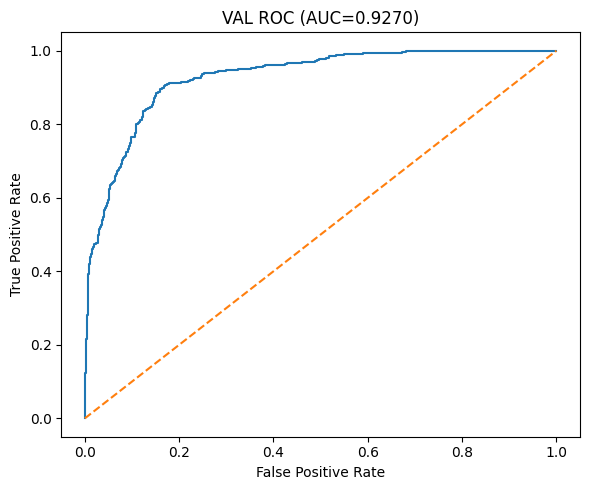

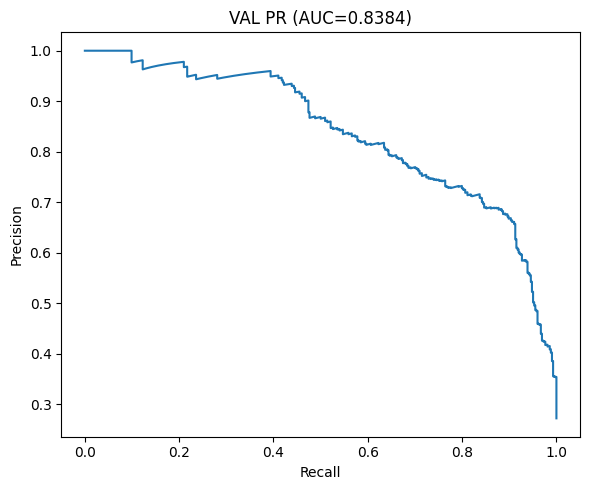

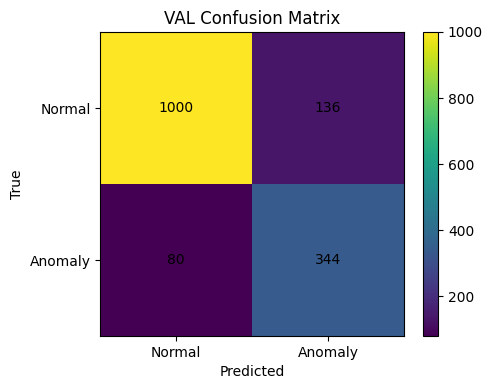

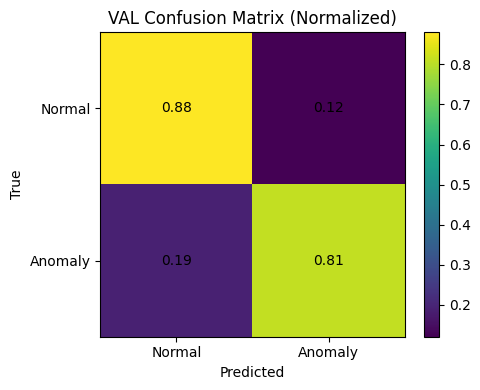


[Threshold tuned on VAL] metric=f1 | best_thr=0.1971 | best_score=0.7724

=== TEST (thr=0.197) ===
Accuracy          : 0.8685
Balanced Accuracy : 0.8423
F1-score          : 0.7614
Precision         : 0.7381
Recall            : 0.7861
ROC-AUC           : 0.9261
PR-AUC            : 0.8543
Confusion Matrix  : [[TN FP], [FN TP]]
TN=1027  FP=116
FN=89  TP=327


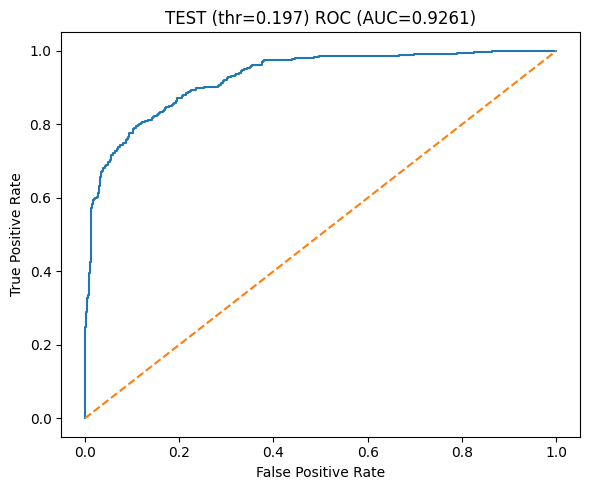

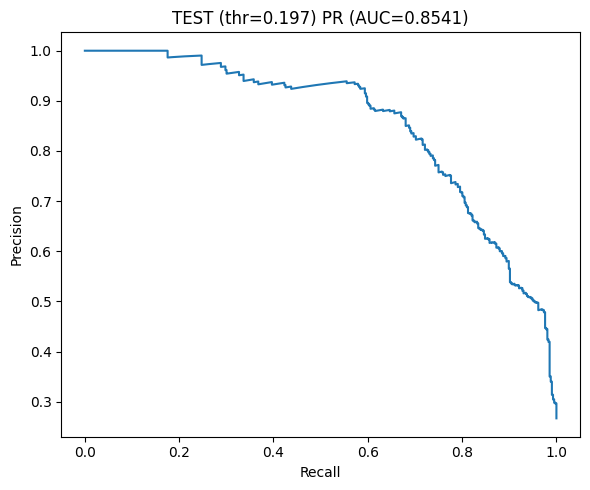

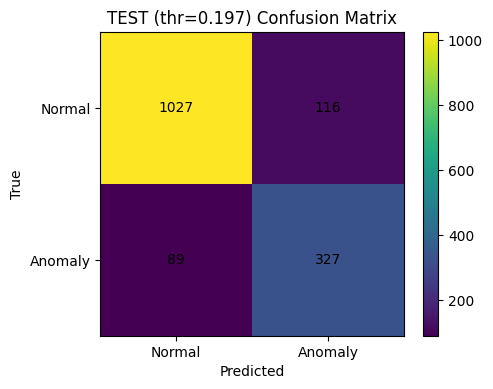

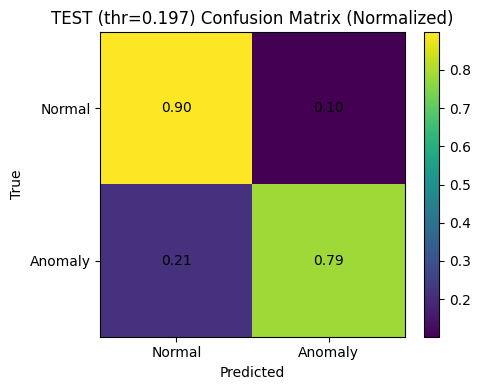


Threshold usado: 0.1971356783919598
TEST PR-AUC: 0.8542961044521054
TEST ROC-AUC: 0.926147452722256
TEST F1: 0.7613504074505238


In [47]:
# ==============================
# EJECUCIÓN FINAL DEL PIPELINE
# ==============================

# Asegúrate que ya existen:
# mlp, X_val_s, y_val, X_test_s, y_test

out = evaluate_pipeline(
    mlp=mlp,
    X_val_s=X_val_s,
    y_val=y_val,
    X_test_s=X_test_s,
    y_test=y_test,
    batch_size=1024,
    thr_mode="tune_on_val",   # ajusta threshold usando VALIDACIÓN
    thr_metric="f1",          # puedes cambiar a "bacc" si quieres
    plot=True                 # muestra ROC, PR y matrices
)

print("\nThreshold usado:", out["thr_used"])
print("TEST PR-AUC:", out["test"]["metrics"]["pr_auc"])
print("TEST ROC-AUC:", out["test"]["metrics"]["roc_auc"])
print("TEST F1:", out["test"]["metrics"]["f1"])


In [51]:
import json
import numpy as np
import torch
from pathlib import Path

# ----------------------------
# Define config (si no existe)
# ----------------------------
MLP_CFG = dict(
    hidden_dims=(512, 256),
    dropout=0.2,
    act="relu",
    lr=3e-4,
    weight_decay=1e-4,
    batch_size=128,
    max_epochs=40,
    patience=7,
    use_pos_weight=True
)

# Si no tienes 'out' (threshold tuneado), usa 0.5
thr_to_save = float(out["thr_used"]) if "out" in globals() else 0.5

OUT_DIR = Path(EXP_DIR) / "baseline_mlp_artifacts"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Guardar MLP
torch.save(mlp.state_dict(), OUT_DIR / "mlp.pt")

# 2) Guardar scaler
np.savez(
    OUT_DIR / "scaler.npz",
    mean=scaler.mean_.astype(np.float32),
    scale=scaler.scale_.astype(np.float32),
)

# 3) Guardar metadata
art = {
    "IN_DIM": int(IN_DIM),
    "MLP_CFG": MLP_CFG,
    "threshold": thr_to_save,
}
with open(OUT_DIR / "artifact_meta.json", "w") as f:
    json.dump(art, f, indent=2)

print("Saved artifacts to:", OUT_DIR)
print("Saved threshold:", thr_to_save)


Saved artifacts to: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/baseline_mlp_artifacts
Saved threshold: 0.1971356783919598


In [52]:
import json
import numpy as np
import torch
from pathlib import Path

OUT_DIR = Path(EXP_DIR) / "baseline_mlp_artifacts"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) MLP
torch.save(mlp.state_dict(), OUT_DIR / "mlp.pt")

# 2) Scaler (para aplicar igual en inferencia)
np.savez(
    OUT_DIR / "scaler.npz",
    mean=scaler.mean_.astype(np.float32),
    scale=scaler.scale_.astype(np.float32),
)

# 3) Config + threshold
art = {
    "IN_DIM": int(IN_DIM),
    "MLP_CFG": MLP_CFG,
    "threshold": float(out["thr_used"]) if "out" in globals() else 0.5,
}
with open(OUT_DIR / "artifact_meta.json", "w") as f:
    json.dump(art, f, indent=2)

print("Saved artifacts to:", OUT_DIR)


Saved artifacts to: /home/DIINF/dvaldes/tesis/artifacts/exp01_timesformer_base/baseline_mlp_artifacts


In [53]:
import time
import numpy as np
import torch

def infer_video_end2end(
    video_path: str,
    *,
    encoder,                 # tu codificador
    image_processor,         # el processor del codificador (si lo usa)
    mlp_mlp,               # tu MLP entrenado (model)
    scaler,                  # StandardScaler entrenado
    thr: float,              # threshold (ideal: tuneado en VAL)
    target_fps: int = 30,
    clip_len: int = 32,
    stride: int = 16,
    max_clips: int = 20,
    max_frames: int = 999999,
    hard_cap_frames: int = 6000,
    decord_chunk: int = 512,
    agg_mode: str = "max",   # "max" recomendado para anomalías
    device: str = "cuda",
):
    """
    Video -> frames -> clips -> embeddings -> scaler -> MLP -> probs por clip -> score video -> pred
    Retorna score final, pred, tiempos, probs por clip.
    """

    t0 = time.perf_counter()

    # 1) Leer frames muestreados
    frames, meta = load_video_frames_sampled(
        video_path=video_path,
        target_fps=target_fps,
        max_frames=max_frames,
        hard_cap_frames=hard_cap_frames,
        decord_chunk=decord_chunk,
    )
    # frames: [T, H, W, 3] uint8 RGB
    T = frames.shape[0]

    # 2) Generar slices de clips (ventana deslizante)
    slices = make_clip_slices(
        n_frames=T,
        clip_len=clip_len,
        stride=stride,
        max_clips=max_clips,
    )
    if len(slices) == 0:
        return {
            "video_path": video_path,
            "error": "Video too short for clip_len",
            "n_frames": int(T),
            "meta": meta,
        }

    t1 = time.perf_counter()

    # 3) Codificar clips -> embeddings
    clip_probs = []
    enc_times = []
    mlp_times = []

    encoder.eval()
    mlp_mlp.eval()

    for (s, e) in slices:
        clip = frames[s:e]  # [clip_len, H, W, 3]

        # 3.1 encoder -> embedding (np.float32 [768])
        te0 = time.perf_counter()
        emb = encode_clip(encoder, image_processor, clip, device=device, use_amp=True)
        te1 = time.perf_counter()

        # 3.2 scaler + mlp -> prob
        tm0 = time.perf_counter()
        emb_s = scaler.transform(emb.reshape(1, -1))  # [1, 768]
        xb = torch.from_numpy(emb_s).float().to(device)

        with torch.no_grad():
            logit = mlp_mlp(xb)
            prob = torch.sigmoid(logit).item()

        tm1 = time.perf_counter()

        clip_probs.append(prob)
        enc_times.append(te1 - te0)
        mlp_times.append(tm1 - tm0)

    t2 = time.perf_counter()

    # 4) Agregación clip -> video
    clip_probs_np = np.array(clip_probs, dtype=np.float32)
    if agg_mode == "max":
        video_score = float(clip_probs_np.max())
    elif agg_mode == "mean":
        video_score = float(clip_probs_np.mean())
    else:
        raise ValueError("agg_mode must be 'max' or 'mean'")

    video_pred = int(video_score >= float(thr))
    t3 = time.perf_counter()

    # 5) Tiempos
    read_time = t1 - t0
    compute_time = t2 - t1
    agg_time = t3 - t2
    total_time = t3 - t0

    return {
        "video_path": video_path,
        "n_frames": int(T),
        "n_clips": int(len(slices)),
        "video_score": float(video_score),
        "video_pred": int(video_pred),
        "threshold": float(thr),
        "agg_mode": agg_mode,
        "clip_probs": clip_probs,
        "time_read_sec": float(read_time),
        "time_compute_sec": float(compute_time),
        "time_agg_sec": float(agg_time),
        "time_total_sec": float(total_time),
        "time_encoder_mean_ms": float(np.mean(enc_times) * 1000.0),
        "time_mlp_mean_ms": float(np.mean(mlp_times) * 1000.0),
        "meta": meta,
    }


In [54]:
ls /home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Videos-Part-2/Explosion


Explosion001_x264.mp4*  Explosion018_x264.mp4*  Explosion036_x264.mp4*
Explosion002_x264.mp4*  Explosion019_x264.mp4*  Explosion037_x264.mp4*
Explosion003_x264.mp4*  Explosion020_x264.mp4*  Explosion038_x264.mp4*
Explosion004_x264.mp4*  Explosion021_x264.mp4*  Explosion039_x264.mp4*
Explosion005_x264.mp4*  Explosion022_x264.mp4*  Explosion040_x264.mp4*
Explosion006_x264.mp4*  Explosion023_x264.mp4*  Explosion041_x264.mp4*
Explosion007_x264.mp4*  Explosion024_x264.mp4*  Explosion042_x264.mp4*
Explosion008_x264.mp4*  Explosion025_x264.mp4*  Explosion043_x264.mp4*
Explosion009_x264.mp4*  Explosion026_x264.mp4*  Explosion044_x264.mp4*
Explosion010_x264.mp4*  Explosion027_x264.mp4*  Explosion045_x264.mp4*
Explosion011_x264.mp4*  Explosion028_x264.mp4*  Explosion046_x264.mp4*
Explosion012_x264.mp4*  Explosion029_x264.mp4*  Explosion047_x264.mp4*
Explosion013_x264.mp4*  Explosion030_x264.mp4*  Explosion048_x264.mp4*
Explosion014_x264.mp4*  Explosion032_x264.mp4*  Explosion050_x264.mp4*
Explos

In [50]:
VIDEO_PATH = "/home/DIINF/dvaldes/tesis/UCF_Crime/Anomaly-Videos-Part-2/Explosion/Explosion002_x264.mp4"

thr_use = float(out["thr_used"]) if "out" in globals() else 0.5

res = infer_video_end2end(
    video_path=VIDEO_PATH,
    encoder=encoder,
    image_processor=image_processor,
    mlp_mlp=mlp,
    scaler=scaler,
    thr=thr_use,
    target_fps=30,
    clip_len=32,
    stride=16,
    max_clips=20,
    agg_mode="max",
    device=DEVICE
)

print("\n===== RESULTADO VIDEO =====")
print("Predicción (1=anomalía):", res["video_pred"])
print("Score:", round(res["video_score"], 4))
print("Clips:", res["n_clips"])
print("Tiempo total (s):", round(res["time_total_sec"], 3))
print("Encoder mean (ms/clip):", round(res["time_encoder_mean_ms"], 2))


NameError: name 'infer_video_end2end' is not defined